In [ ]:
"""
if not uint8:
orb.detectAndCompute(img2, None) will raise an error

"""

In [1]:
import cv2
import time
import numba
import pygad
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob

In [18]:
@numba.njit
def error_diffusion_quantization(img, h=None, method="custom", N=1):

    # Processing
    if method == "jjn":
        ## Jarvis, Judice & Ninke
        h = np.array([[0, 0, 0, 7, 5],
                      [3, 5, 7, 5, 3],
                      [1, 3, 5, 3, 1]]) / 48
        FSTEPJ = 2
        BSTEPJ = -2
        FSTEPI = 2 
    if method == "fs":
        ## floyd-Steinburg
        h = np.array([[0, 0, 7],
                      [3, 5, 1]]) /16
        FSTEPJ = 1
        BSTEPJ = -1
        FSTEPI = 1
    if method == "custom":
        if h.shape[0]*h.shape[1] == 6:
            FSTEPJ = 1
            BSTEPJ = -1
            FSTEPI = 1
        if h.shape[0]*h.shape[1] == 15:
            FSTEPJ = 2
            BSTEPJ = -2
            FSTEPI = 2
    
    level = pow(2, N)
    d = 255 / (level-1)

    tmp1 = np.concatenate((np.ones((img.shape[0], -BSTEPJ)), img, np.ones((img.shape[0], FSTEPJ))), axis=1)
    tmp2 = np.concatenate((np.ones((FSTEPI, -BSTEPJ)), np.ones((FSTEPI, img.shape[1])), np.ones((FSTEPI, FSTEPJ))), axis=1)
    tmp = np.concatenate((tmp1, tmp2), axis=0)

    newImage = np.zeros((img.shape[0]+FSTEPI, img.shape[1]+FSTEPJ - BSTEPJ), dtype=np.int64)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]+FSTEPJ):
            if (i > img.shape[0] or j > img.shape[1] - BSTEPJ or j <= -BSTEPJ):
                newImage[i,j] = np.round(newImage[i,j] / d) * d
            else:
                tmp_ceil  = np.ceil(tmp[i,j] / d) * d
                tmp_floor = np.floor(tmp[i,j] / d) * d 

                err1 = tmp[i,j] - tmp_floor
                err2 = tmp[i,j] - tmp_ceil

                if (err1 * err1 < err2 * err2):
                    newImage[i,j] = tmp_floor
                    err3 = err1
                else:
                    newImage[i,j] = tmp_ceil
                    err3 = err2

                for k in range(1, FSTEPI + 2):
                    for l in range(BSTEPJ, FSTEPJ+1):
                        tmp[i+k-1, j+l] += err3 * h[k-1, -1*BSTEPJ+l]

    return newImage[:-FSTEPI, FSTEPJ:BSTEPJ].astype(np.uint8)



class ORBFilterGA(object):
    def __init__(self, bit=1, nfeatures1bit=1000, scaleFactor1bit=1.2, nlevels1bit=8,
                       num_generations=100, num_parents_mating=4, sol_per_pop=10, num_genes=12, gene_space=float,
                       init_range_low=0, init_range_high=1, parent_selection_type="sss", keep_parents=2, 
                       crossover_type="single_point", mutation_type="random", mutation_percent_genes=33):
        
        self.nfeatures    = nfeatures1bit
        self.scaleFactor  = scaleFactor1bit
        self.nlevels      = nlevels1bit
        
        self.imgs = None
        self.ga_instance = None
        
        self.count = 0
        self.bit = bit
        self.num_generations = num_generations
        self.num_parents_mating = num_parents_mating
        self.sol_per_pop = sol_per_pop
        self.num_genes = num_genes              # 4(6-2) or 12(15-3)
        self.gene_space = gene_space            # w_range + orbparams
        self.init_range_low  = init_range_low
        self.init_range_high = init_range_high
        self.parent_selection_type = parent_selection_type
        self.keep_parents = keep_parents
        self.crossover_type = crossover_type
        self.mutation_type = mutation_type
        self.mutation_percent_genes = mutation_percent_genes
        
        self.acc_history = [0.0]
        self.acc_ave = None
    
    
    def set_dataset_and_config(self, directory=None, imgs=None, N=-1, num_genes=None, gene_space=None):
        if imgs:
            self.imgs = imgs
        
        if directory:
            img_paths = glob(f"{directory}*")

            if N != -1: img_paths = np.random.choice(img_paths, N)

            self.imgs = []

            for path in img_paths:
                img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
                self.imgs.append(img) 
        
        if type(num_genes)  != type(None):   self.num_genes  = num_genes
        if type(gene_space) != type(None):   self.gene_space = gene_space 
        
        print(f"Dataset and config parameters has been ready!")
        print(f"All {len(self.imgs)} images in dataset!")
    
    
    def error_diffusion_quantization(self, img, w, method="custom", N=1):
        return error_diffusion_quantization(img, w, method, N)
    
    
    def orb_matching_accuracy(self, img_8bit, img_nbit, extractor_params=None):

        orb_8bit = cv2.ORB_create(
                nfeatures     = 1000,
                scaleFactor   = 1.2,
                nlevels       = 8,
        )

        orb_nbit = cv2.ORB_create(
                nfeatures     = self.nfeatures,
                scaleFactor   = self.scaleFactor,
                nlevels       = self.nlevels,
        )

        try:
            keypoints_8bit, descriptors_8bit = orb_8bit.detectAndCompute(img_8bit, None)
            keypoints_nbit, descriptors_nbit = orb_nbit.detectAndCompute(img_nbit, None)

            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = bf.match(descriptors_8bit, descriptors_nbit)
            min_dist = 10000
            max_dist = 0

            for match in matches:
                dist = match.distance
                if dist < min_dist:
                    min_dist = dist
                if dist > max_dist:
                    max_dist = dist

            good_matches = []

            for match in matches:
                if match.distance <= max(2 * min_dist, 30.0):
                    good_matches.append(match)

            acc = len(good_matches)/len(descriptors_8bit)

        except Exception as e:
            acc = 0

        return acc

    
    def target_function(self, w):
            
        accs = []
        w = list(np.array(w) / np.sum(w))

        if len(w) == 6-2:  w = np.array([0,0] + list(w)).reshape(2, 3)
        if len(w) == 15-3: w = np.array([0,0,0] + list(w)).reshape(3, 5)
            
        
        for img in self.imgs:
            quantized_img = self.error_diffusion_quantization(img, w, N=self.bit)
            acc = self.orb_matching_accuracy(img, quantized_img)
            accs.append(acc)
        
        self.count += 1
        self.acc_ave = np.mean(accs)
        
        if self.acc_ave > max(self.acc_history):
            print(f"Best Accuracy: {np.round(self.acc_ave, 5)*100}% [{self.count} times]")
            self.acc_history.append(self.acc_ave)
        
        return self.acc_ave
    
    
    def fitness_func(self, ga_instance, solution, solution_idx):
        
        if len(solution) not in [4, 12]:
            self.nfeatures   = int(solution[0])
            self.scaleFactor = solution[1]
            self.nlevels     = int(solution[2])
            solution         = solution[3:]
        
        solution_fitness = self.target_function(solution) * 100
        return solution_fitness
        
        
    def optimizationGA(self):
        
        self.acc_history = [0.0]
        
        ga_instance = pygad.GA(num_generations=self.num_generations,
                               num_parents_mating=self.num_parents_mating, 
                               fitness_func=self.fitness_func,
                               sol_per_pop=self.sol_per_pop, 
                               num_genes=self.num_genes,
                               gene_space=self.gene_space,
                               parent_selection_type=self.parent_selection_type,
                               keep_parents=self.keep_parents,
                               crossover_type=self.crossover_type,
                               init_range_low=self.init_range_low,
                               init_range_high=self.init_range_high,
                               mutation_type=self.mutation_type,
                               mutation_percent_genes=self.mutation_percent_genes)

        ga_instance.run()
        
        self.ga_instance = ga_instance
    
    
    def show_result(self):
        self.ga_instance.plot_fitness()

        solution, solution_fitness, solution_idx = self.ga_instance.best_solution()
        
        print(f"Parameters of the best solution:")
        print(f"[nfeatures]  : {solution[0]}")
        print(f"[scaleFactor]: {solution[1]}")
        print(f"[nlevels]    : {solution[2]}")
        print(f"[filter(int)]: {list(np.array(solution[3:]))}")
        print(f"[filter]     : {list(np.array(solution[3:])/np.sum(solution[3:]))}")
        print(f"Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

In [4]:
# data_dir = "imgs/train_imgs/*"
data_dir = "/Users/tsy/slamFolder/datasets/euroc/MH_05_difficult/MH05_8bit/cam0/data/*"

# x_range =  [0,  5]
x_range = [0, 15]
gene_space = [
    [1000+10*x for x in range(0, 16)],              # nfeatures
    [1.2],                                          # scaleFactor
    [8],                                            # nlevels
    [x for x in range(x_range[0], x_range[1])],     # filter --- w1
    [x for x in range(x_range[0], x_range[1])],     # filter --- w2
    [x for x in range(x_range[0], x_range[1])],     # filter --- w3
    [x for x in range(x_range[0], x_range[1])],     # filter --- w4
    [x for x in range(x_range[0], x_range[1])],     # filter --- w5
    [x for x in range(x_range[0], x_range[1])],     # filter --- w6
    [x for x in range(x_range[0], x_range[1])],     # filter --- w7
    [x for x in range(x_range[0], x_range[1])],     # filter --- w8
    [x for x in range(x_range[0], x_range[1])],     # filter --- w9
    [x for x in range(x_range[0], x_range[1])],     # filter --- w10
    [x for x in range(x_range[0], x_range[1])],     # filter --- w11
    [x for x in range(x_range[0], x_range[1])],     # filter --- w12
]

num_genes = len(gene_space)


ofg = ORBFilterGA(num_generations=100, bit=5)
ofg.set_dataset_and_config(directory=data_dir, N=300, gene_space=gene_space, num_genes=num_genes)
ofg.optimizationGA()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


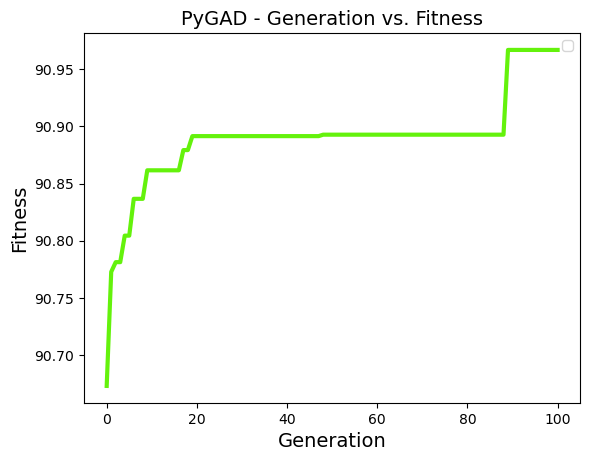

Parameters of the best solution:
[nfeatures]  : 1150.0
[scaleFactor]: 1.2
[nlevels]    : 8.0
[filter(int)]: [4.0, 1.0, 2.0, 1.0, 4.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0]
[filter]     : [0.2222222222222222, 0.05555555555555555, 0.1111111111111111, 0.05555555555555555, 0.2222222222222222, 0.05555555555555555, 0.05555555555555555, 0.05555555555555555, 0.1111111111111111, 0.0, 0.0, 0.05555555555555555]
Fitness value of the best solution = 90.96692900971077


In [10]:
ofg.show_result()

In [16]:
# res = [0.38, 0.1, 0.38, 0.14]
res = [12.0, 7.0, 3.0, 8.0, 14.0, 6.0, 2.0, 2.0, 1.0, 3.0, 1.0, 0.0]
# w = np.array([0, 0] + res).reshape(2, 3)   # [15 5 8 4]
w = np.array([0, 0, 0] + res).reshape(3, 5)
w = w / np.sum(w)

# w = np.array([[0, 0, 7], [3, 5, 1]]) / 16
# w = np.array([[0, 0, 0, 7, 5], [3, 5, 7, 5, 3], [1, 3, 5, 3, 1]]) / 48

img_paths = glob("imgs/test_imgs/*")[:]

accs = []
ofg = ORBFilterGA(num_generations=1, nfeatures1bit=1140, scaleFactor1bit=1.2, nlevels1bit=8)

for path in img_paths:
    img   = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    q_img = ofg.error_diffusion_quantization(img, w, N=2)
    
    acc = ofg.orb_matching_accuracy(img, q_img)
    
    accs.append(acc)

print(np.mean(accs))

0.518804883525511


In [19]:
import cv2
import pandas as pd
from glob import glob

N_range = [460, 500] # mh01:950, 2000
target_idx = 4
target     = "MH05"


DIR0 = "/Users/tsy/slamFolder/datasets/euroc/"
DIR1 = ["MH_01_easy/", "MH_02_easy/", "MH_03_median/", "MH_04_difficult/", "MH_05_difficult/"]
DIR2 = [f"block_wise/{target}_BW_N{n}" for n in [4, 8, 16]] +\
       [f"error_diffusion/{target}_{t}_1bit" for t in ["floyd", "jarvis"]] +\
       [f"visual_model/{target}_visual_{i}bit" for i in range(1, 8)] +\
       [f"uniform/{target}_uniform_{i}bit" for i in range(1, 8)]
DIR3 = "/cam0/data/*"

DIR2_ref = f"{target}_8bit"
 
ofg1 = ORBFilterGA()
ofg2 = ORBFilterGA(num_generations=1, nfeatures1bit=1140, scaleFactor1bit=1.2, nlevels1bit=8)
accs = {"Block4": [], "Block8": [], "Block16": [],
        "Err.Diff.\nFloyd\n1bit": [], "Err.Diff.\nJarvis\n1bit": [],
        "Err.Diff.\nWeight[6]\n1bit": [], "Err.Diff.\nWeight[6]\n2bit": [], "Err.Diff.\nWeight[6]\n3bit": [], "Err.Diff.\nWeight[6]\n4bit": [], "Err.Diff.\nWeight[6]\n5bit": [], "Err.Diff.\nWeight[6]\n6bit": [], "Err.Diff.\nWeight[6]\n7bit": [],
        "Linear\n1bit": [], "Linear\n2bit": [], "Linear\n3bit": [], "Linear\n4bit": [], "Linear\n5bit": [], "Linear\n6bit": [], "Linear\n7bit": []}
accs_keys = list(accs.keys())

for n in range(N_range[0], N_range[1]):
    
    img_ref = cv2.cvtColor(cv2.imread(glob(DIR0+DIR1[target_idx]+DIR2_ref+DIR3)[n]), cv2.COLOR_BGR2GRAY)
    
    for i, d in enumerate(DIR2):
        img_target = cv2.cvtColor(cv2.imread(glob(DIR0+DIR1[target_idx]+DIR2[i]+DIR3)[n]), cv2.COLOR_BGR2GRAY)    
        
        if "optim" not in d:  
            acc = ofg1.orb_matching_accuracy(img_ref, img_target)
        else:         
            acc = ofg2.orb_matching_accuracy(img_ref, img_target)
        
        accs[accs_keys[i]].append(acc)
        

df, df_res = pd.DataFrame(accs), pd.DataFrame({})

df_res['mean'] = df.mean()*100
df_res['std']  = df.std()*100

df_sorted = df_res.sort_values('mean')
df_sorted

,mean,std
Linear\n1bit,4.092095,3.172354
Block16,8.023963,4.114331
Block8,18.599450,3.822622
Linear\n2bit,18.924342,9.481452
Err.Diff.\nJarvis\n1bit,29.988158,6.270997
Err.Diff.\nFloyd\n1bit,31.186552,7.822040
Err.Diff.\nWeight[6]\n1bit,33.249626,6.901151
Block4,39.015983,4.363193
Linear\n3bit,54.674764,11.581169
Err.Diff.\nWeight[6]\n2bit,55.779778,8.212378


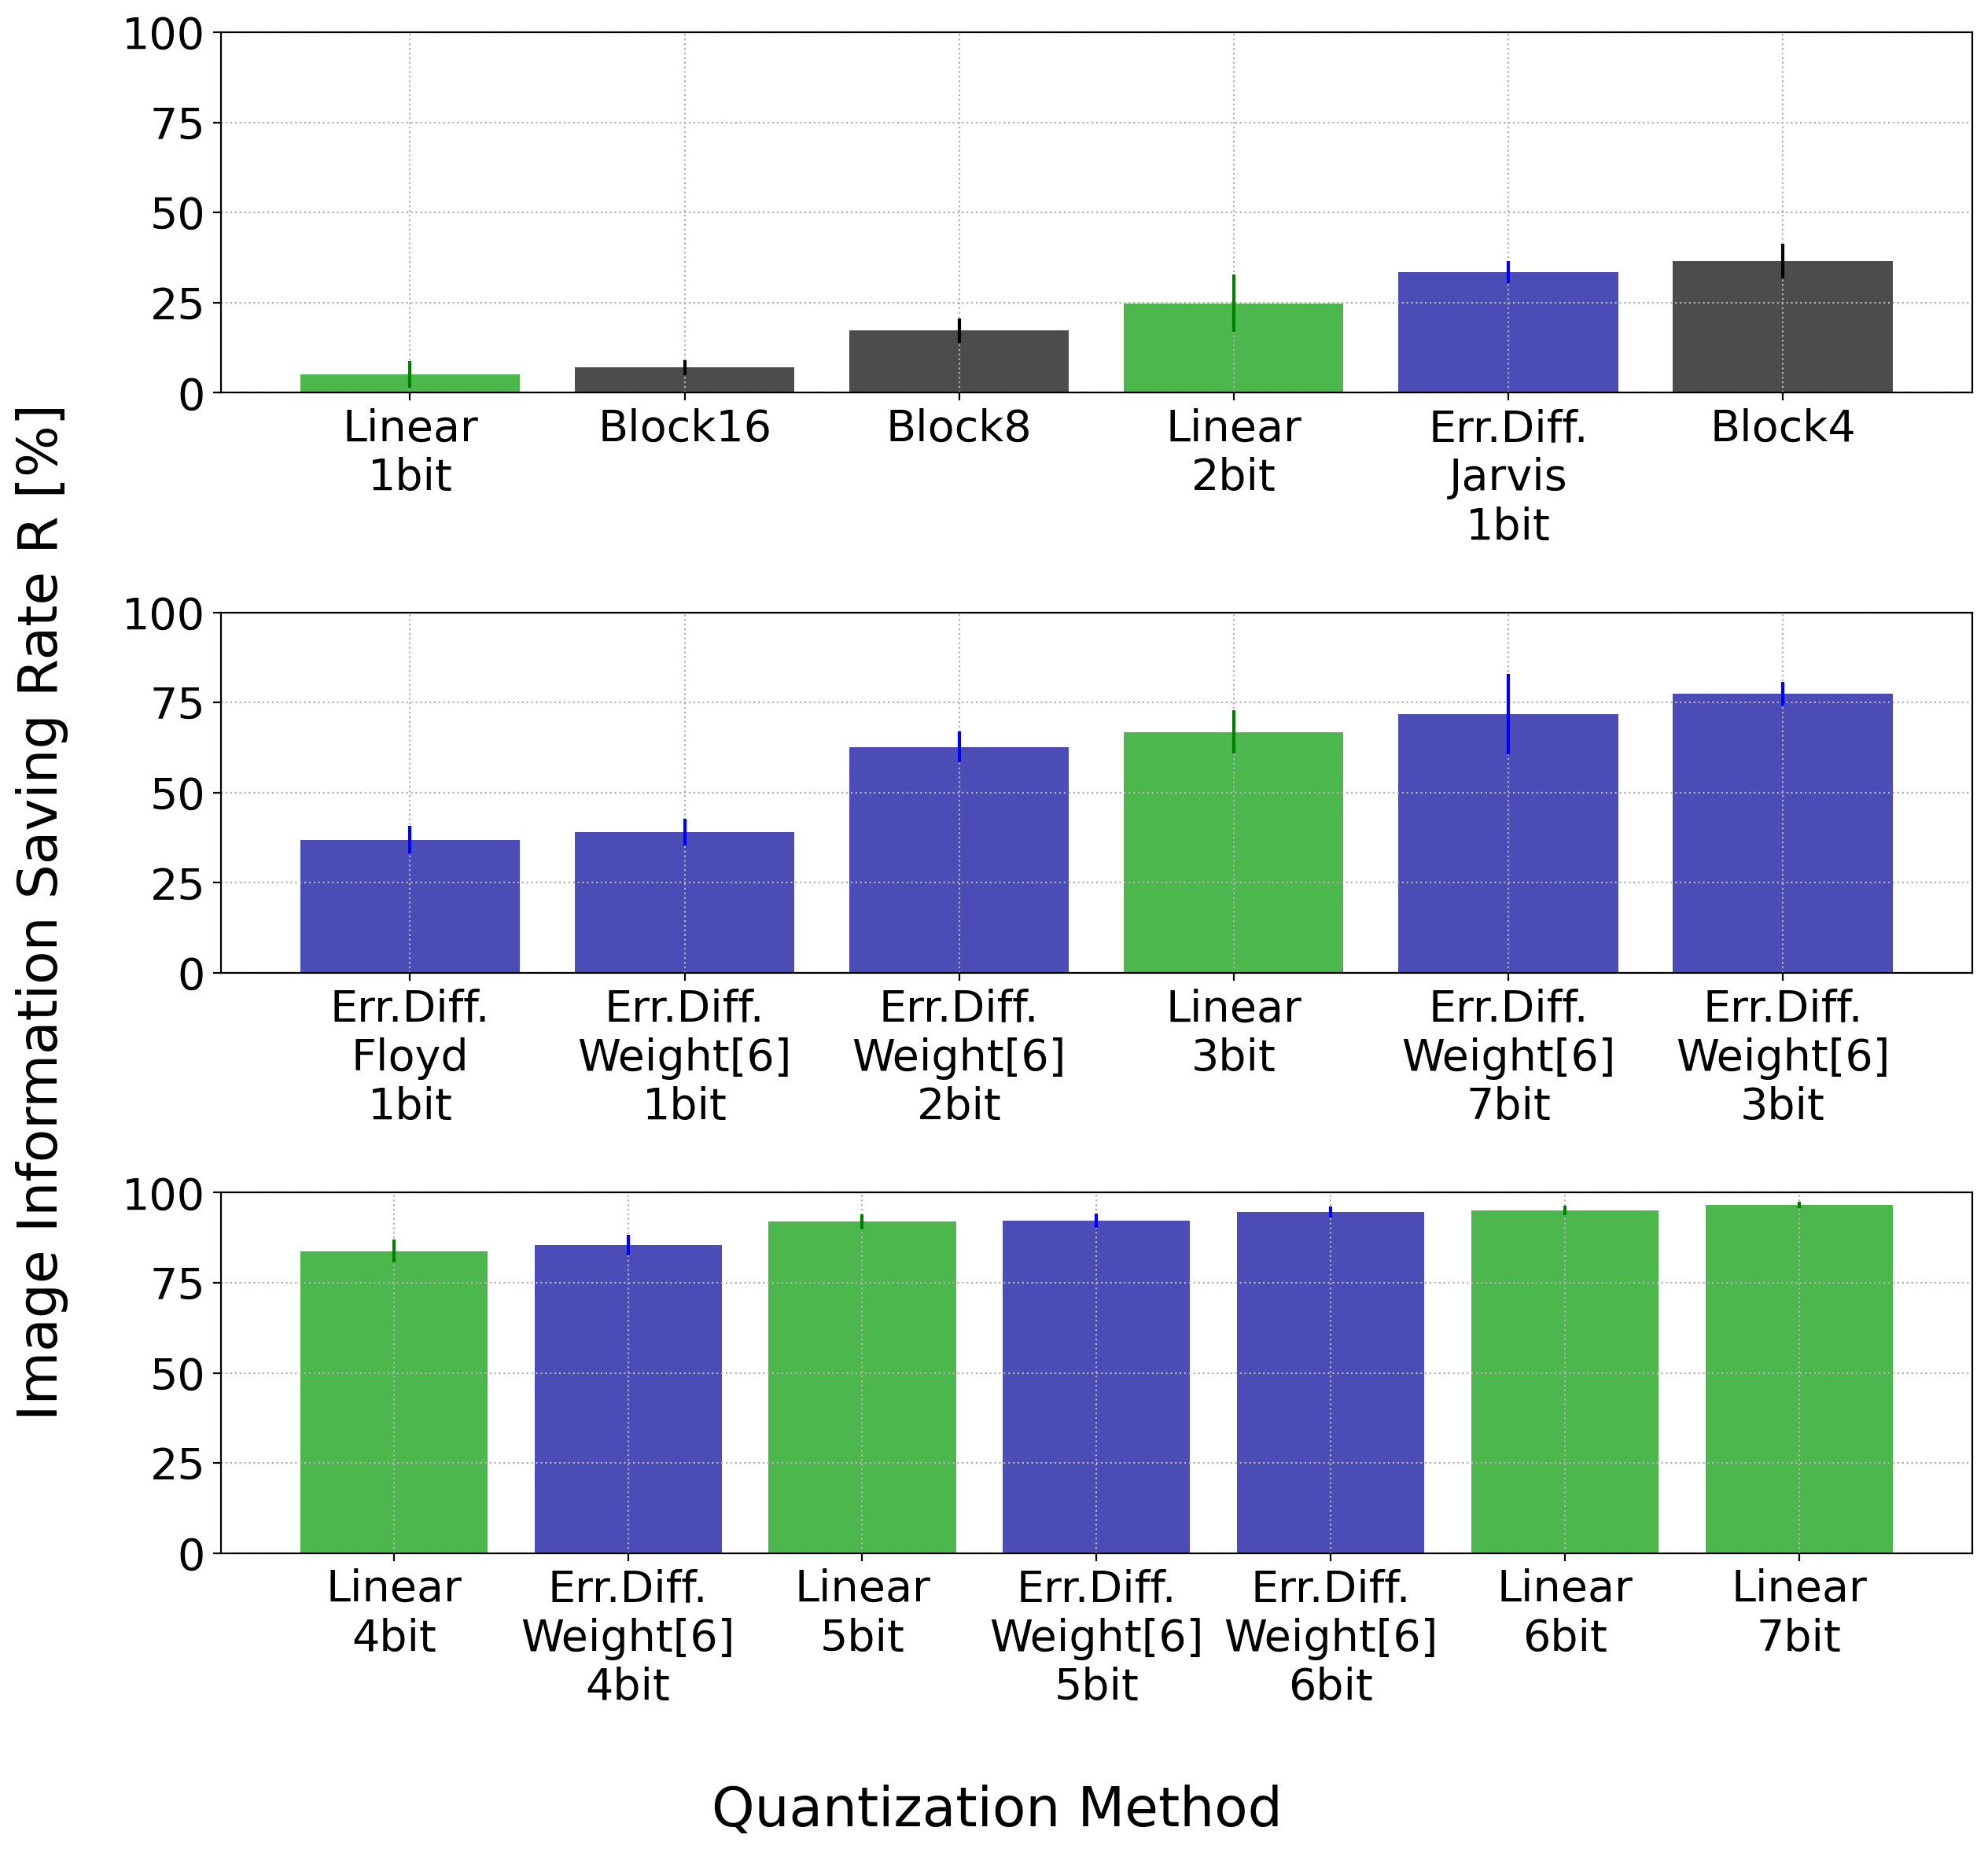

In [151]:
plt.rcParams["font.size"] = 20
colors = [(0,0,0,.7), (0,.6,0,.7), (0,0,.6,.7)]

count     = 0
count_th1 = 6
count_th2 = 12

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(13, 12), dpi=200)

df_sorted_mean = df_sorted['mean']
df_sorted_std = df_sorted['std']

# plt.bar([k for k in df_sorted.index], [v for v in df_sorted], color="k")
for k, v in zip(df_sorted_mean.index, df_sorted_mean):
    if count < count_th1:
        if 'Block' in k:     axes[0].bar(k, v, yerr=df_sorted_std[k], color=colors[0], ecolor="k")
        if 'Linear' in k:    axes[0].bar(k, v, yerr=df_sorted_std[k], color=colors[1], ecolor="g")
        if 'Err.Diff.' in k: axes[0].bar(k, v, yerr=df_sorted_std[k], color=colors[2], ecolor="b")
    elif count < count_th2:
        if 'Block' in k:     axes[1].bar(k, v, yerr=df_sorted_std[k], color=colors[0], ecolor="k")
        if 'Linear' in k:    axes[1].bar(k, v, yerr=df_sorted_std[k], color=colors[1], ecolor="g")
        if 'Err.Diff.' in k: axes[1].bar(k, v, yerr=df_sorted_std[k], color=colors[2], ecolor="b")
    else:
        if 'Block' in k:     axes[2].bar(k, v, yerr=df_sorted_std[k], color=colors[0], ecolor="k")
        if 'Linear' in k:    axes[2].bar(k, v, yerr=df_sorted_std[k], color=colors[1], ecolor="g")
        if 'Err.Diff.' in k: axes[2].bar(k, v, yerr=df_sorted_std[k], color=colors[2], ecolor="b")
    
    count +=1


axes[0].set_ylim(0, 100)
axes[1].set_ylim(0, 100)
axes[2].set_ylim(0, 100)

axes[0].set_xticks(range(len([i for i in range(len(df_sorted.index))][:count_th1])), df_sorted.index[:count_th1])
axes[1].set_xticks(range(len([i for i in range(len(df_sorted.index))][count_th1:count_th2])), df_sorted.index[count_th1:count_th2])
axes[2].set_xticks(range(len([i for i in range(len(df_sorted.index))][count_th2:])), df_sorted.index[count_th2:])

axes[0].grid(True, alpha=1, ls=":")
axes[1].grid(True, alpha=1, ls=":")
axes[2].grid(True, alpha=1, ls=":")


fig.supxlabel("Quantization Method", fontsize=25)
fig.supylabel("Image Information Saving Rate R [%]", fontsize=25)

plt.tight_layout()
plt.show()

In [21]:
import cv2
import pandas as pd
from glob import glob

N_range = [500, 550] # mh01:950, 2000
target_idx = 4
target     = "MH05"


DIR0 = "/Users/tsy/slamFolder/datasets/euroc/"
DIR1 = ["MH_01_easy/", "MH_02_easy/", "MH_03_median/", "MH_04_difficult/", "MH_05_difficult/"]
DIR2 = [f"block_wise/{target}_BW_N{n}" for n in [4, 16]] +\
       [f"visual_model/{target}_visual_{i}bit" for i in range(1, 3)] +\
       [f"uniform/{target}_uniform_{i}bit" for i in range(1, 4)]
DIR3 = "/cam0/data/*"

DIR2_ref = f"{target}_8bit"
 
ofg1 = ORBFilterGA()
ofg2 = ORBFilterGA(num_generations=1, nfeatures1bit=1140, scaleFactor1bit=1.2, nlevels1bit=8)
accs = {"Block4": [], "Block16": [],
        "Err.Diff.\nWeight[6]\n1bit": [], "Err.Diff.\nWeight[6]\n2bit": [],
        "Linear\n1bit": [], "Linear\n2bit": [], "Linear\n3bit": []}
accs_keys = list(accs.keys())

for n in range(N_range[0], N_range[1]):
    
    img_ref = cv2.cvtColor(cv2.imread(glob(DIR0+DIR1[target_idx]+DIR2_ref+DIR3)[n]), cv2.COLOR_BGR2GRAY)
    
    for i, d in enumerate(DIR2):
        img_target = cv2.cvtColor(cv2.imread(glob(DIR0+DIR1[target_idx]+DIR2[i]+DIR3)[n]), cv2.COLOR_BGR2GRAY)    
        
        if "optim" not in d:  
            acc = ofg1.orb_matching_accuracy(img_ref, img_target)
        else:         
            acc = ofg2.orb_matching_accuracy(img_ref, img_target)
        
        accs[accs_keys[i]].append(acc)
        

df, df_res = pd.DataFrame(accs), pd.DataFrame({})

df_res['mean'] = df.mean()*100
df_res['std']  = df.std()*100

df_sorted = df_res.sort_values('mean')
df_sorted

,mean,std
Linear\n1bit,5.540611,4.418777
Block16,8.339514,4.606013
Linear\n2bit,21.921735,10.240188
Err.Diff.\nWeight[6]\n1bit,34.855234,7.622732
Block4,38.227239,4.844598
Linear\n3bit,56.267030,12.734066
Err.Diff.\nWeight[6]\n2bit,57.858669,8.255651


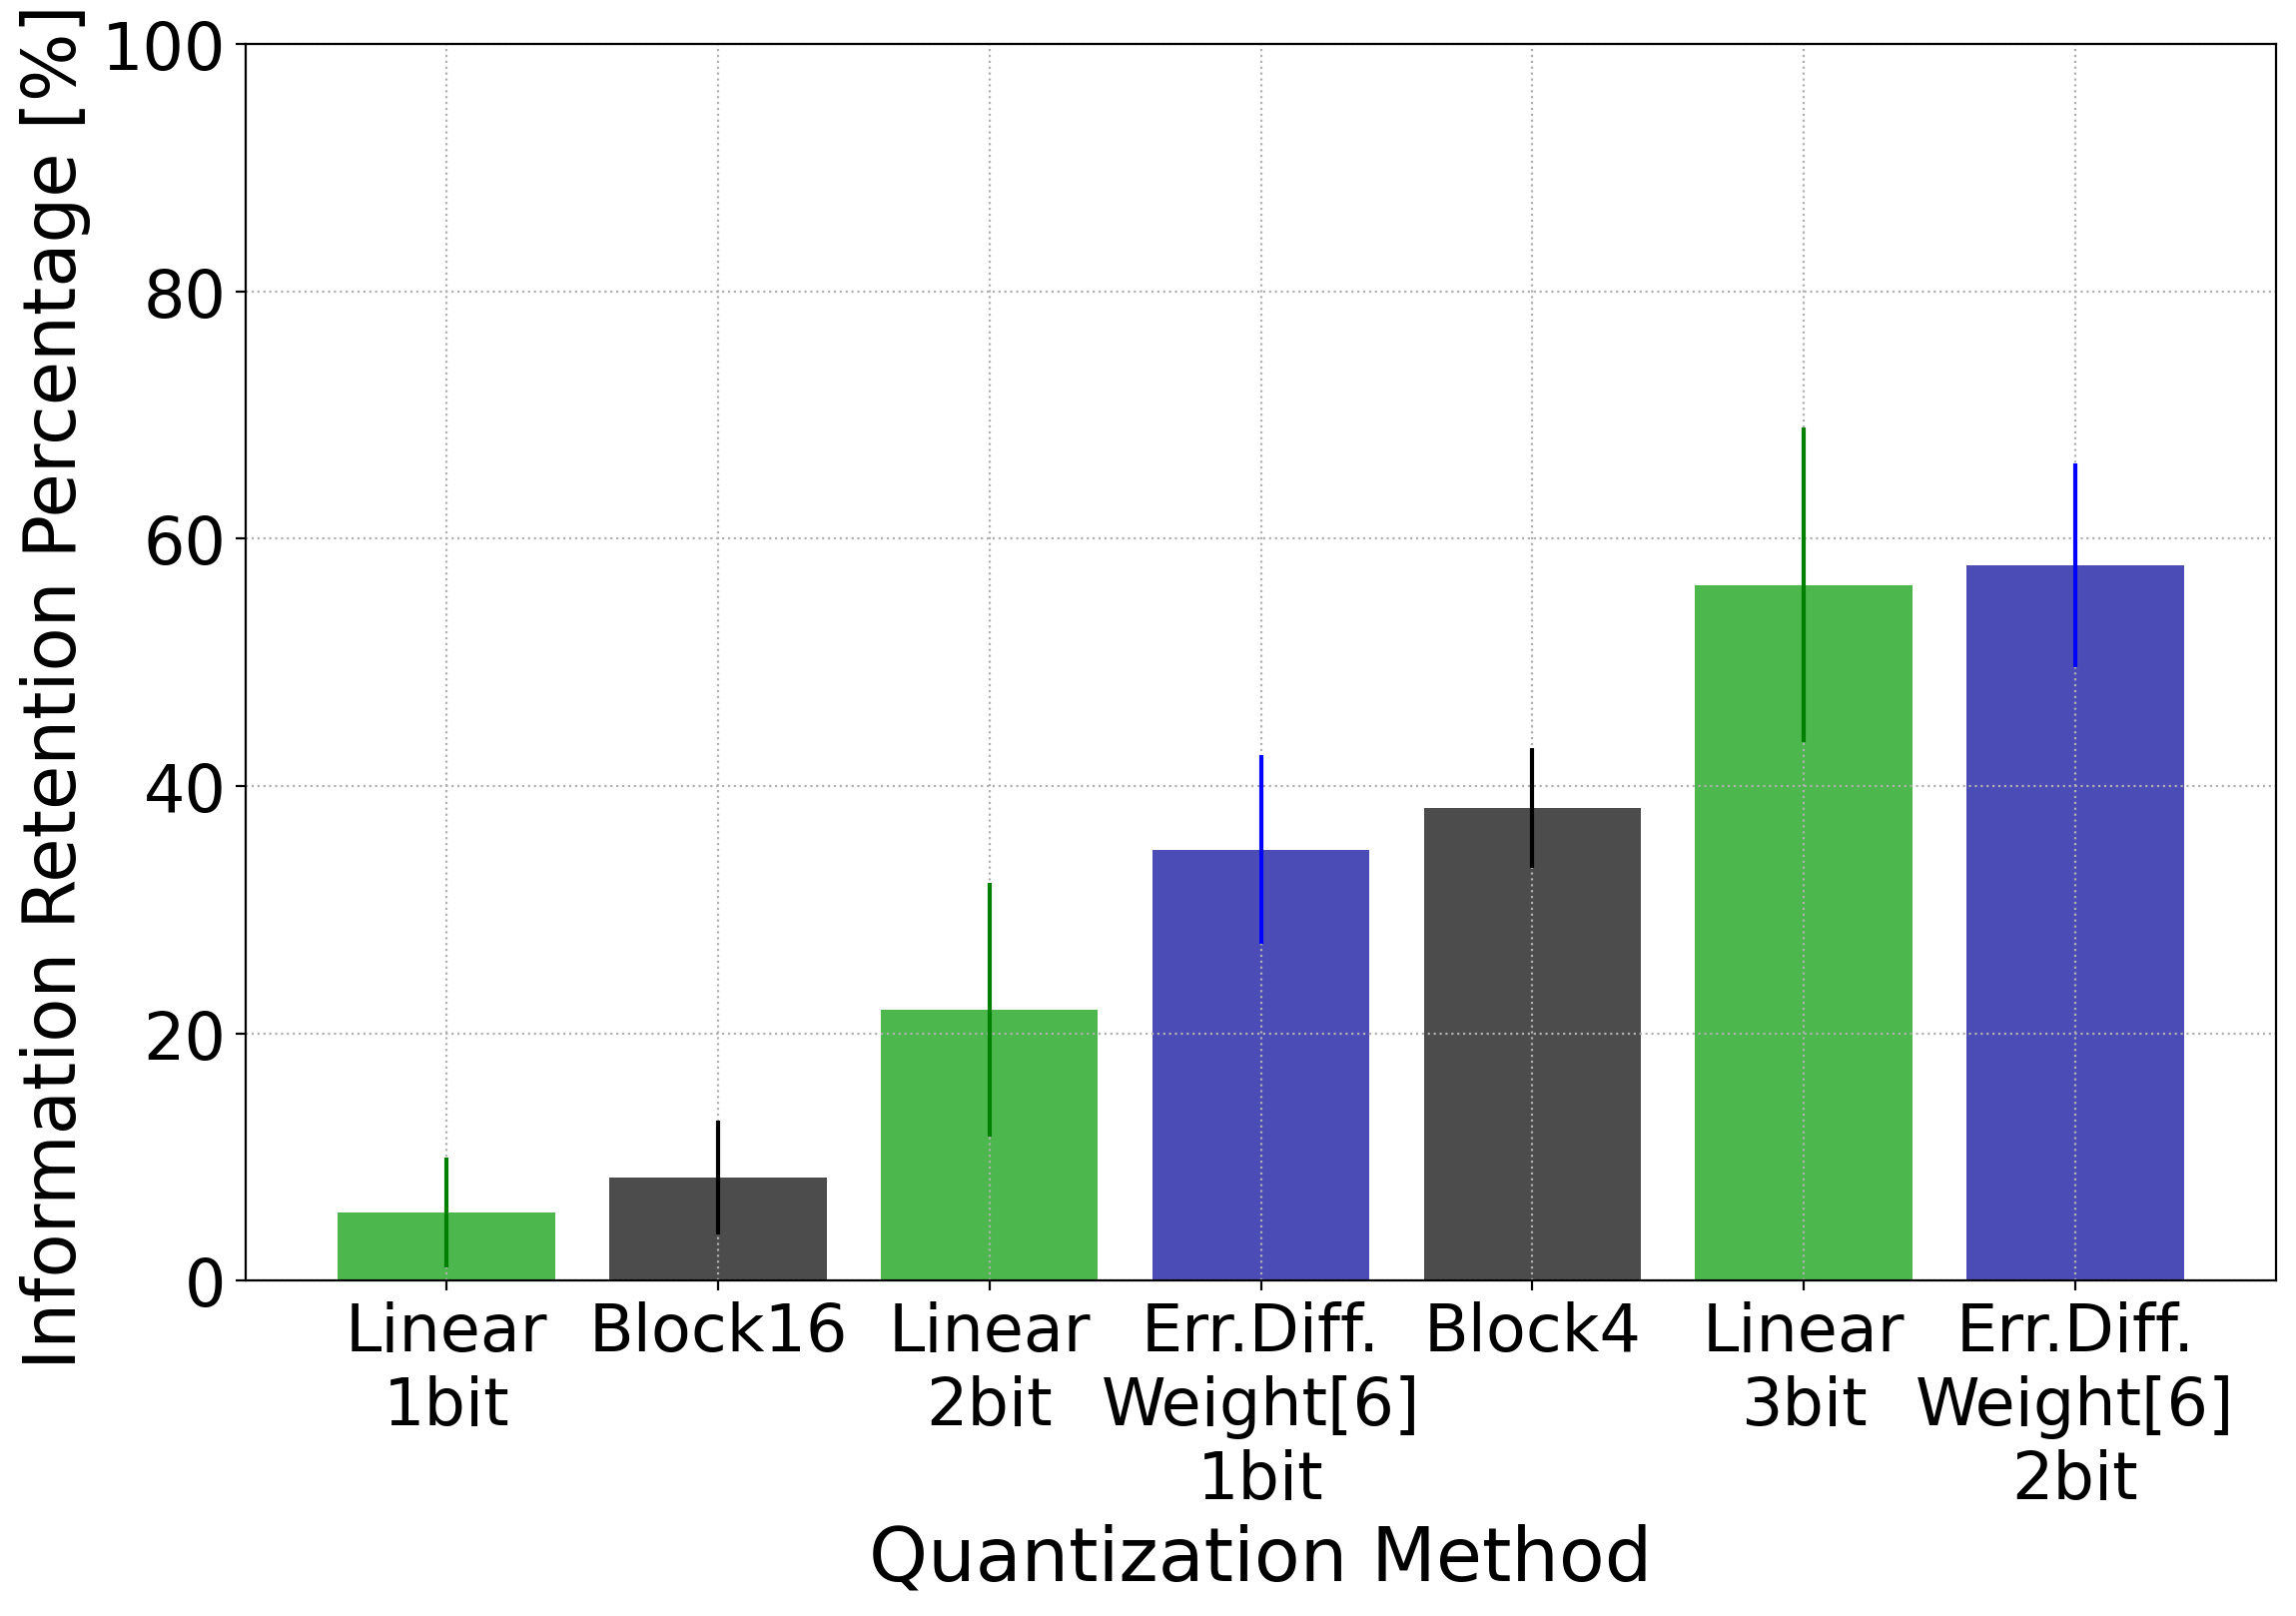

In [44]:
# MH01
plt.rcParams["font.size"] = 23.5
colors = [(0,0,0,.7), (0,.6,0,.7), (0,0,.6,.7)]

plt.figure(figsize=(12, 8.6), dpi=200)

df_sorted_mean = df_sorted['mean']
df_sorted_std = df_sorted['std']

# plt.bar([k for k in df_sorted.index], [v for v in df_sorted], color="k")
for k, v in zip(df_sorted_mean.index, df_sorted_mean):
    if 'Block' in k:     plt.bar(k, v, yerr=df_sorted_std[k], color=colors[0], ecolor="k")
    if 'Linear' in k:    plt.bar(k, v, yerr=df_sorted_std[k], color=colors[1], ecolor="g")
    if 'Err.Diff.' in k: plt.bar(k, v, yerr=df_sorted_std[k], color=colors[2], ecolor="b")


plt.ylim(0, 100)
plt.xticks(range(len([i for i in range(len(df_sorted.index))])), df_sorted.index)


plt.grid(True, alpha=1, ls=":")


plt.xlabel("Quantization Method", fontsize=27)
plt.ylabel("Information Retention Percentage [%]  ", fontsize=26)

plt.tight_layout()
plt.show()

In [55]:
[round(i,3) for i in df_res['mean']]

[39.016,
 18.599,
 8.024,
 31.187,
 29.988,
 33.25,
 55.78,
 70.312,
 81.048,
 89.237,
 92.162,
 69.66,
 4.092,
 18.924,
 54.675,
 76.726,
 88.689,
 93.1,
 95.342]

Slope:       -0.9193122825039939; 
Intercept:   75.71919216183835; 
Pearson's r: -0.8853880836732478


(-40.0, 100.0)

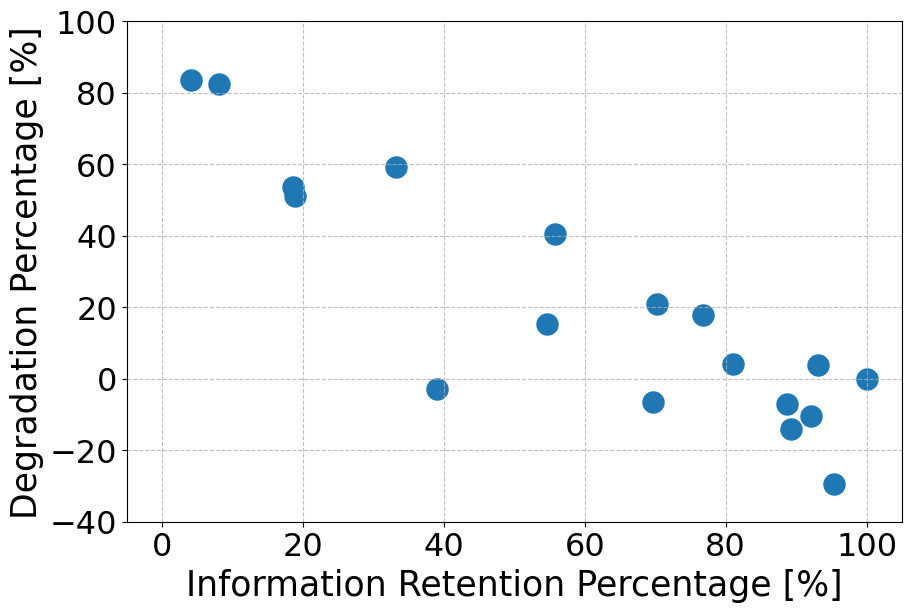

In [45]:
# MH05
# uniform_1bit    0.4777
# uniform_2bit    0.1612
# uniform_3bit    0.0929
# uniform_4bit    0.0960
# uniform_5bit    0.0736
# uniform_6bit    0.0819
# uniform_7bit    0.0609
# visual_1bit     0.1931
# visual_2bit     0.1321
# visual_3bit     0.0997
# visual_4bit     0.0821
# visual_5bit     0.0691
# visual_6bit     0.0714
# visual_7bit     0.0740
# BW_N4           0.0767
# BW_N8           0.1702
# BW_N16          0.4505
# 8bit            0.0788

from scipy.stats import linregress

plt.rcParams["font.size"] = 23
ate_deg = [0.3989, 0.0824, 0.0141, 0.0172, 0.000, 0.0031, 0.0000, 0.1143, 0.0533, 0.0209, 0.0033, 0.0000, 0.0000, 0.000, 0.0000, 0.0914, 0.3717, 0.000]
ate_res = [0.4777, 0.1612, 0.0929, 0.096, 0.0736, 0.0819, 0.0609, 0.1931, 0.1321, 0.0997, 0.0821, 0.0691, 0.0714, 0.074, 0.0767, 0.1702, 0.4505, 0.0788]
msr_res = [4.092, 18.924, 54.675, 76.726, 88.689, 93.1, 95.342, 33.25, 55.78, 70.312, 81.048, 89.237, 92.162, 69.66, 39.016, 18.599, 8.024, 100]

x_range = np.array(msr_res)
y_range = 100*(1 - 0.0788/np.array(ate_res))

# y_range = np.array(ate_deg)

slope, intercept, r_value, p_value, std_err = linregress(x_range, y_range)
print(f"Slope:       {slope}; \nIntercept:   {intercept}; \nPearson's r: {r_value}")


plt.figure(figsize=(10, 6.5), dpi=100)
plt.scatter(x_range, y_range, marker="o", s=230)
# plt.plot(np.linspace(-5, 105, 200), slope*np.linspace(-5, 105, 200)+intercept, c='k', ls='--')
plt.grid(True, alpha=.8, ls="--")

plt.xlabel("Information Retention Percentage [%]", fontsize=25)
plt.ylabel("Degradation Percentage [%]", fontsize=25)
plt.xlim(-5, 105)
plt.ylim(-40, 100)
# plt.yticks(np.arange(0, 0.5, 0.1))

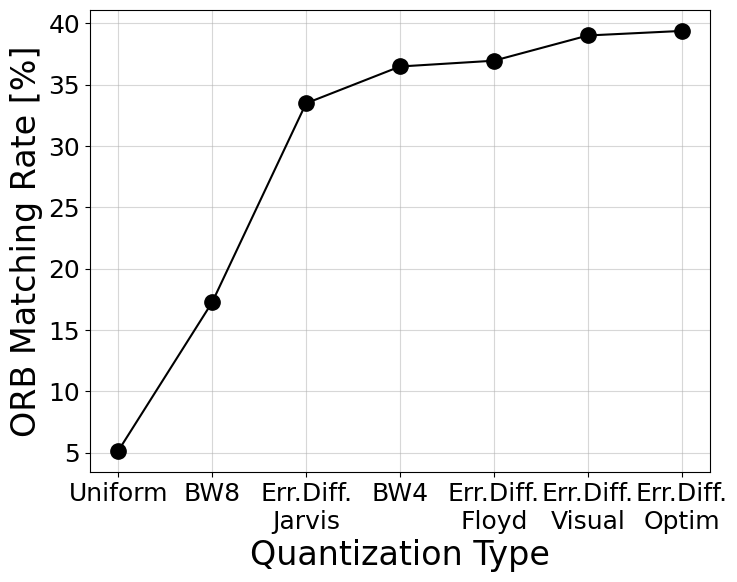

In [89]:
plt.figure(figsize=(8, 6), dpi=100)
(df.mean()*100).sort_values().plot(marker="o", color="k", markersize=11, fontsize=18)
plt.xlabel("Quantization Type", fontsize=24)
plt.ylabel("ORB Matching Rate [%]", fontsize=24)
plt.grid(True, alpha=.5)

In [145]:
np.round(w, 5)

array([[0.        , 0.        , 0.39130435],
       [0.13043478, 0.39130435, 0.08695652]])

In [171]:
def target_function(w, imgs):
    
    accs = []
    w = list(np.array(w) / np.sum(w))
    
    if len(w) == 6-2:  w = np.array([0,0] + list(w)).reshape(2, 3)
    if len(w) == 15-3: w = np.array([0,0,0] + list(w)).reshape(3, 5)
    if len(w) == 24-4: w = np.array([0,0,0] + list(w)).reshape(4, 6)
        
    for img in imgs:
        quantized_img = halftone_error_diffusion(img, w)
        acc = orb_matching_accuracy(img, quantized_img)
        accs.append(acc)
    
    acc_ave = np.mean(accs)
    print(acc_ave)
    
    return acc_ave


In [268]:
num_generations = 3000
num_parents_mating = 4

sol_per_pop = 10
num_genes = 12      # 4(6-2) or 12(15-3)
gene_space = np.linspace(1, 100, 100)   # w_range

init_range_low  = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 2

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 33

def fitness_func(ga_instance, solution, solution_idx):
    global imgs
    solution_fitness = target_function(solution, imgs=imgs) * 100
    return solution_fitness

In [269]:
N = 20
img_paths = glob("imgs/train_imgs/*")
img_paths_random = np.random.choice(img_paths, N)
imgs = []

for path in img_paths_random:
    img = cv2.imread(path, cv2.COLOR_BGR2GRAY)
    imgs.append(img)

In [270]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating, 
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop, 
                       num_genes=num_genes,
                       gene_type=int,
                       gene_space=gene_space,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

ga_instance.run()

0.2776387028031492
0.28758350941772226
0.2900724612588367
0.29886545516104335
0.2727632521362192
0.28717094824062817
0.2919062075483788
0.279901490547641
0.29369626049059433
0.27549673605266173
0.2918682579205503
0.29482139786845674
0.29026710637973613
0.29613140796505844
0.28939762418127474
0.2911898539543003
0.28975599539851266
0.3035121764065104
0.28953362311273206
0.2984891409142707
0.28982338831045584
0.2881948593056725
0.29758837760771145
0.28866586729463023
0.2953384276577616
0.2892231246817752
0.29795791007270245
0.29350729566071265
0.29641093753788395
0.2827132906695623
0.2961914433897566
0.30945327936067557
0.29722666602588743
0.2940988877718549
0.29378627511594635
0.2891763784978751
0.29457084731790617
0.2979932579205503
0.29580191545351586
0.28351137582218894
0.2778109253717385
0.2891065208374465
0.2935597620977378
0.2982730499097713
0.29518920373660856
0.28652883030088916
0.299242794308149
0.29094420887150124
0.28790010213500694
0.29248810181288554
0.2950996891787982
0.306

0.2927794815576823
0.31235399283366405
0.310175439106927
0.31597032109964635
0.30166173812220526
0.31214239390774856
0.3035977372701421
0.3104872384062262
0.3019775914322627
0.2998443336935551
0.30052530255168663
0.29989251872980244
0.3129419191683033
0.3043592737633828
0.3071844109247656
0.3088403670106092
0.3075126771234903
0.31108886511944467
0.3131458102566234
0.3070653670106092
0.2995078468174056
0.31044666110747426
0.31104140446675055
0.3005741891112566
0.2927527543547008
0.31016778153586116
0.30509991410095216
0.3168670930013058
0.30897984407417795
0.30784639704583466
0.2909368633339221
0.30768927829213294
0.30921163823858455
0.311251665419745
0.3079272410819124
0.3025612011665645
0.3065437705871962
0.3120464473123643
0.30955498084589783
0.3038256891406978
0.297590291632463
0.313948937821905
0.3069209729625819
0.29955644524282066
0.30813376049059443
0.31412852939444635
0.2903877403354912
0.3103128142848731
0.3034553563078649
0.3156138653359241
0.30153820212946514
0.3089932948086

0.31386725592374376
0.29744851313250964
0.3051673813519402
0.31787845566154393
0.3067575094558226
0.30823811436869397
0.308198824949517
0.30532621518577396
0.2849972738309243
0.31470339201658404
0.304796072673019
0.2961133518466563
0.30689020430465075
0.30870764683368496
0.3162439580151085
0.3075952216056887
0.29909464654966383
0.31202851787773933
0.30256681802910174
0.313114278292133
0.2953295555070642
0.2982988504940927
0.30612735395430035
0.3086269401754696
0.30939109200030485
0.3000534175611598
0.30640339223306345
0.3125925568301866
0.3083360879045135
0.2997550813356609
0.29054240668003645
0.30702217373082424
0.30781567904409596
0.3040680315696319
0.2971393789983755
0.3058741256827762
0.3125776923549848
0.2960166054895726
0.3086888152858741
0.3099879891569771
0.2842056073807371
0.29551942102136747
0.3021431569978283
0.29538742665676054
0.299910098636699
0.30433649982162087
0.304891680867719
0.3020471356304401
0.3083904543384215
0.3079592480023276
0.30812838006691823
0.3079695464495

0.3032714979685568
0.2890639026136864
0.2943650916487422
0.3078415688179529
0.30651811911392357
0.30648723840622627
0.3022633392908479
0.3046121263564603
0.30476132516599647
0.31655755889973014
0.3058346492253499
0.3047760275413822
0.304006519798345
0.30219055361589964
0.3071442836435051
0.3035295310015898
0.30534298277516275
0.31124433347707575
0.30724494663348473
0.31170916006837285
0.31254093033344754
0.3101605746317252
0.30169776238175894
0.30754204273477626
0.30371260213500695
0.300580244258099
0.298564165419745
0.3045086978847359
0.30349342023684583
0.3124225621815587
0.302080057046666
0.31040614554866286
0.30459553550089885
0.3025861375216047
0.2960144908316621
0.30887550171278544
0.29884074268905586
0.2956589359688408
0.30514194367377756
0.30875842208991
0.29607726744911
0.3080570336772759
0.30949373227033267
0.31249216920207407
0.3059220235806741
0.30749148066751875
0.2998343728243814
0.2935394156699953
0.3026522538542002
0.31190665799882933
0.30241624236693443
0.3035917681955

0.29939546012275253
0.304007633671734
0.30202142319655295
0.3118191332768755
0.3181663179615602
0.3142336103404443
0.2983159676112098
0.3014784676112098
0.30024348305918375
0.3009286055952146
0.2959504016126853
0.28995104091981255
0.3127645410981916
0.3036693709713173
0.29208894132021296
0.2924447585994299
0.30149968857265574
0.31113319738423545
0.30569086751110974
0.30886964633318437
0.3114780418827131
0.3118205091337012
0.3028842609910949
0.2926384399970905
0.3059894035038499
0.3039791808677189
0.304225038923006
0.3098590733467031
0.3000870884725556
0.3030585475181063
0.30759776155913693
0.302168907748579
0.31123272160568877
0.3109931949250289
0.3027944836272259
0.30266865749832883
0.31074693543023996
0.3053803816359612
0.31071864494252044
0.3009528289102251
0.30577442637273955
0.3021205600063731
0.29124499646705526
0.3010995890786981
0.31161081189320805
0.298127053654
0.3067903797828971
0.2910341606745154
0.3079441081652587
0.30113125759842885
0.29951829563127136
0.30377968115174
0.

0.3060045565461655
0.30740622053714617
0.2955653544548008
0.2945846238972537
0.29850664544302086
0.2997215733467031
0.31169723573054026
0.30050483130189015
0.3020088222738309
0.30330498145204027
0.29836556721080937
0.3067657045886717
0.2996154296164676
0.3027602370536627
0.2889343616973375
0.3081440951764914
0.30453640054414277
0.3081848483864487
0.31092910548957264
0.30491646789523086
0.2861363129998511
0.30381920826535874
0.29368314733418543
0.30375760873330077
0.28809301961996603
0.30697332466549593
0.3099409420666341
0.30040435552334344
0.30434582259595244
0.3064818326544538
0.3048196457270419
0.2906977370536627
0.30999990111218484
0.3089104990370994
0.30718118222028257
0.30945550706415753
0.29897879323960636
0.28318441114124504
0.2986363383279473
0.3110412050891722
0.3065768034037498
0.3001517780756536
0.2971779296164678
0.3121538677951307
0.2953756518629357
0.30171590561149386
0.3078690078486791
0.2870621393452276
0.29438084485869953
0.3106474361472199
0.30721251398457283
0.29982

0.31498035691400744
0.28897710370405005
0.2999195470557062
0.30837309935367896
0.3063255019292649
0.30795037732369046
0.3039757146852735
0.2951174441742781
0.3020971858969696
0.30828319820685735
0.3046616380221052
0.30387669096432074
0.28623721429041493
0.3110988877718549
0.29904103021706824
0.31394150435037116
0.2994905680334313
0.2904982999435422
0.2947533553449643
0.30916671814548113
0.2929951971002144
0.30042168621909104
0.31912407519976715
0.30415177889827544
0.311010824665496
0.30206330201308573
0.29907283715376276
0.3053620384225055
0.30977152351313253
0.30716806988649553
0.28867198608643246
0.30965649529287076
0.30530297988299726
0.30926928342702564
0.29811208825607616
0.3137980752378677
0.31202720380415017
0.3068274048269723
0.30980943564671937
0.29887740400435037
0.3067663805674187
0.3063602868872332
0.31234642341303237
0.30447097213996
0.30642284970957123
0.31229900025457985
0.3095965478021273
0.30950468115174
0.2980291561457652
0.3088279042883714
0.298465116760359
0.3130887

0.30720515693028666
0.3113986995213206
0.30491133772180484
0.30214246867975236
0.3028854873039129
0.31484963873908506
0.3154757019129856
0.29469452090498804
0.30034616039049433
0.3063183819199823
0.29803217127161763
0.31146656799533096
0.3123673438576985
0.2968436193979446
0.28885031450135257
0.3092149660040663
0.29146962161123063
0.29956844495879964
0.2974315581152086
0.3132329463113632
0.3145604743151456
0.3003276295326468
0.3151651289265044
0.2913579343616973
0.3060464734630825
0.3075436329928544
0.30369604751810636
0.2989621766229898
0.3075824093557225
0.3064431574307872
0.3132394537703794
0.28964744930917075
0.31112441277782976
0.31025685841550893
0.3016166306011895
0.30452522613443894
0.31000784703388506
0.29983444902514966
0.3074348986529782
0.30104636059069456
0.28864370754837887
0.30412626501934464
0.30280289255518494
0.30705588213646173
0.30388870323610806
0.30643116944799464
0.30638382227383093
0.30492263695356253
0.30456910816525873
0.3074690834433049
0.30834843732140443
0.

0.3094672942406074
0.3081693707548379
0.30547958105163986
0.3007322093720017
0.30423218300480415
0.3033484119933082
0.3038430070641576
0.2990985510164143
0.3118404045048509
0.31042979320150604
0.3093819580826501
0.3055650667103089
0.31117747877635427
0.3070245256502177
0.3075880773074112
0.3004662176449806
0.3079097485028281
0.29677425089449305
0.30162379962142066
0.30208933985889
0.2951571090554222
0.2974239625438588
0.30425823466199764
0.3049791178289016
0.30260887336298237
0.3041047932015061
0.3062285429893561
0.3016626515789146
0.301732859806173
0.30911789358562713
0.30907830447229234
0.30801472913224637
0.3125060075646581
0.3075238126101881
0.3120499013286643
0.30271845729812863
0.31027627779163247
0.30532989473037053
0.3056188204207668
0.3169373012285642
0.2964456720561392
0.3054727117255664
0.30159468382742605
0.3067653299493265
0.2988800442743781
0.30304621022406486
0.3011916678789516
0.31072572641845997
0.2986448838111468
0.297617518513323
0.3033171193685035
0.3148567708712172

0.30635660855492175
0.2903544434572981
0.30685187899837557
0.31746048730391296
0.3074483874878339
0.31161051180938726
0.30266062446529574
0.3100919683957314
0.307284036068941
0.3046749141009521
0.3043909420666341
0.30859099211668417
0.30694091673853785
0.31178338459566834
0.2876466732303238
0.30941864515899986
0.31038612496579626
0.3106234494875499
0.3092062950926705
0.3026821584993298
0.3017174695023743
0.31608553735396294
0.29863157067101703
0.3007468983689572
0.3028003517791148
0.30308125781490836
0.3103079593001306
0.30839996354485977
0.3058962223902103
0.29398113277637494
0.29812283715376275
0.30145071446879396
0.3054013778917325
0.3056980618594374
0.30661049985972133
0.30455886037421503
0.30119084218301345
0.30716304002964906
0.3057134527693783
0.3124404918326631
0.30942406242747944
0.3044467109410448
0.30958308368922555
0.3083498385063264
0.30452666624236696
0.31407552643473924
0.292882533961297
0.2993474740311246
0.300907521621968
0.2984594980360984
0.2973871255338384
0.3161225

0.3135623762170475
0.2978820202988456
0.30898578738773375
0.29015913595256154
0.3094185069585156
0.30766245137871434
0.3057528410763705
0.313985323558853
0.30613775250163655
0.2901393167821801
0.3068638906640204
0.303648824949517
0.3040528795664176
0.30670020162896455
0.30952643989144857
0.30972346204335827
0.31153462389725367
0.3076454971840352
0.28762849272282665
0.2875869261562601
0.2922212475018271
0.30937193564671933
0.3067133395073274
0.300425828163804
0.3077402669105091
0.2965491378056257
0.308425815824475
0.3050837485409285
0.3011161923168844
0.30385697167756
0.2962281419828133
0.3108017908479414
0.29908961543723656
0.2872542562458652
0.30451093836050586
0.308445308933501
0.2959475496257503
0.29873937899837555
0.30913124504262046
0.31074305733068713
0.30197599026362004
0.30344562282871107
0.30443351024034415
0.31282161084094473
0.31068914091427063
0.29384587286248187
0.30531500410445045
0.29681842023684585
0.31008655091077236
0.31628243325505434
0.2976593481024277
0.29539556000

0.30038745137871437
0.3002567842496475
0.3076170184457814
0.30485385584546487
0.3107603369372832
0.3016382027356076
0.28930923665880415
0.3085536428729768
0.3124141151532155
0.3027403291267045
0.28582025948959344
0.3032712985909785
0.3104937705871962
0.3044541687015735
0.31056979587719213
0.31836238855637644
0.3093842107245654
0.30346571736095956
0.3088066707711171
0.3062549940078486
0.316159861375216
0.3056680445583992
0.30209468382742605
0.304029331840491
0.2927963101076855
0.30558368489596865
0.308886150510372
0.30227744149859204
0.3165900788764543
0.30958830201308574
0.2913915185514234
0.2975093608747155
0.29138328553466963
0.30582166089099483
0.3150714479185068
0.31067045990627307
0.31198467394730367
0.30512983130189014
0.31457453842250555
0.3121516406977912
0.30559789997610065
0.3088489625438587
0.30328274671730554
0.306778004604951
0.28979921400639397
0.3046075341777764
0.31001704355739823
0.3085045812681193
0.3133493135003516
0.30755698302108336
0.3073446465496638
0.31722885523

0.3084229745316251
0.30712871764498056
0.3111902660878872
0.30466770698033674
0.30834655996827276
0.30836263962924865
0.31073827729113196
0.28942730472687217
0.2977237876717548
0.3037284548389219
0.2972651161542165
0.30518894049759104
0.3028563954092501
0.30376928342702564
0.303532746933785
0.30957371229360847
0.30144363299285437
0.2936294572686874
0.3015273413984919
0.3137719236970534
0.30544057976661787
0.3142842854965692
0.30687769153236283
0.31590254159869213
0.305748374715546
0.3088979242650956
0.30312752964902623
0.30563293436169736
0.305935148686749
0.30920481852960224
0.3084153795664176
0.29344676077461546
0.2933191582153088
0.31026353949104807
0.30754860024384245
0.295460362481859
0.3074868382223054
0.3033720855803901
0.30498884061397036
0.30171206375060183
0.30968278442802666
0.29877951844578143
0.30610974932545
0.30767278688723326
0.2990080717395596
0.30247500225138635
0.2970283302333475
0.3049157921329634
0.30480890981812264
0.30930083929084795
0.3085661049890721
0.29983601

0.29214189362372756
0.3018267037366086
0.29778929188704273
0.3121069955768918
0.29204041727713875
0.2957776801888393
0.3026217982688571
0.31259857491574616
0.30426758237476237
0.30054935099459323
0.3149033172445802
0.31894862557193876
0.304851778292133
0.3139741388447271
0.30754323176983217
0.3081225860808906
0.30308950360395
0.30369910052786353
0.2979060211595678
0.2978188076484789
0.306945196883735
0.3026878517791148
0.3060112122936085
0.31495167797555335
0.3048732999435422
0.30124133051736857
0.3087137396912484
0.29718169609921335
0.30236978392752617
0.29673244663348475
0.30445191627613777
0.2963072091555224
0.2999528289102251
0.2991925323247122
0.2852011910699627
0.29945395512294304
0.2863446343835184
0.3045899159540163
0.30238802704088175
0.3003799940078487
0.2993751769070109
0.31657692844228313
0.2870348864868328
0.2907915177288014
0.3007297557072644
0.29545010213500694
0.30501176345030145
0.3059419181292019
0.30110784621126313
0.29186257680691075
0.3111897421210138
0.29469016598

0.31087427561644687
0.2980412295946466
0.2955429061414355
0.29007222438701674
0.30377447560016757
0.3058954218058889
0.2994815828371624
0.298565942889256
0.3100448967999141
0.30296246393452275
0.28782905522304314
0.29324362043704605
0.2944445590053722
0.2996773413984919
0.29964925171711504
0.31116052458167504
0.2976612122936085
0.3096587604905943
0.31274992687324
0.29721397838149566
0.304740442605235
0.30459938827235544
0.2934922682630728
0.29841934624936356
0.2896394790984756
0.3038148792823966
0.3093290807676188
0.30297159785217753
0.30945798419526793
0.29430733397757625
0.3085345483026279
0.3030437829265252
0.2867822600281943
0.31298725117851417
0.30641778153586113
0.3074545054570141
0.297845471855939
0.31343524960947106
0.31132139786845675
0.3083754143849732
0.2992108747155459
0.31648743942904844
0.3062334103567236
0.31058836461894423
0.3054462852125482
0.3127121265729398
0.3146676561076648
0.3077117251334379
0.30423357224006015
0.2979815581152086
0.2853430824423039
0.3084047812518

0.2900625395291485
0.3101817836435051
0.3064470237971535
0.3044074468499641
0.30703223305485416
0.3120480871875336
0.3104128017290647
0.30442510235148645
0.3109943711877968
0.303203742150455
0.30828692555011755
0.30270837286248187
0.31089166809543106
0.31031235127861423
0.3065182447585995
0.3032700595058727
0.3070010903637201
0.3073523166765381
0.30305324268905587
0.30793989144854195
0.28497491574619604
0.3011958848121478
0.30882208579686954
0.300308760274115
0.308819633777376
0.3056510275413822
0.29809726127511593
0.3019556327088334
0.30252332548811794
0.3043310701705165
0.3082722985528782
0.3011656425889557
0.31406850778113754
0.30460642052086695
0.30981426530336564
0.3106797567463657
0.31286301448507337
0.29935907334670303
0.3060153797828971
0.2955977498259505
0.3071003015125852
0.2998310829428044
0.30685982305835247
0.31564951309440925
0.3031020038204294
0.30752457570026775
0.3136821968161934
0.3163109247655961
0.31477009700011427
0.31099029163246295
0.3048767033036496
0.2889209218

0.3106859875879339
0.30772251152536617
0.301571485196269
0.30975934810242767
0.31228044363567714
0.30772346225983765
0.31689116698878805
0.29373961729895987
0.3047180320025908
0.31028372342931165
0.31160077729113195
0.31216450299780746
0.2944221490088705
0.30433220833290037
0.3044813459653425
0.3140962223902103
0.31052296197581664
0.31108250884968014
0.3101065704545376
0.3175207599900939
0.30463150867130107
0.2997927059412354
0.3090497011284641
0.3059223867033124
0.2939019782758538
0.30991113752160465
0.29715250471059296
0.31207755415450056
0.29615037689073154
0.3058327972003145
0.3092100992428415
0.30811510420455057
0.3114889279417826
0.30854100488897196
0.29823584856482777
0.3079232245653959
0.2965476367370831
0.29928841570809567
0.2898401295326469
0.30483547431514557
0.30737830408262934
0.300367018229302
0.30444233130189013
0.30411654348985667
0.31450770904988035
0.29629155604566504
0.30593371044054435
0.31188235891600946
0.3100533669049672
0.30412183636924117
0.3014102743314249
0.3

0.3050249641510022
0.29818817719103186
0.3124205717395596
0.31398280914998045
0.3142751896792987
0.3067200469500643
0.31029971390075195
0.3036761150856739
0.31161354031367006
0.31214943914502735
0.30510102732490274
0.3122918310178691
0.2842552454703839
0.30998720134494356
0.31424557195603914
0.31431580447229235
0.3053094980360984
0.3128346986692575
0.31297445087821385
0.3061998265566605
0.3063239508106722
0.3106430701029749
0.30418163327687553
0.30953815186293554
0.30740449372382767
0.30748074475859943
0.3108205847283269
0.2979749767068106
0.314995634778377
0.31351572952710494
0.291570748040428
0.30665564548112123
0.30982353620921954
0.3047708720398599
0.3132444457433211
0.29897050995632307
0.29872477672308984
0.2887316077322997
0.3073142026975072
0.299785699843442
0.31256517897655445
0.3055262028031492
0.30662626501934465
0.32046625513922233
0.3042084476344856
0.30386246393452276
0.29021165140053545
0.3099137903474409
0.3059334731790614
0.300195860090194
0.3147668565624448
0.307198362

0.31108421072456544
0.30932465129489356
0.3093378768907316
0.29950046465150276
0.2925268281257035
0.30221775681390733
0.3031074468499642
0.3024378157136375
0.30429085452234245
0.31027354958764997
0.30906516620426655
0.3120373133947096
0.31520882188416793
0.29316857017051656
0.30844608501234794
0.2950141281419828
0.30038901526959483
0.30824021625431663
0.2905303315859112
0.3116844109247656
0.31065868489596865
0.3130884641129018
0.30864190557339344
0.3088161675949305
0.29787232388097445
0.30248927829213296
0.30951798195254077
0.2886535180509229
0.3100976870036126
0.3141087477183065
0.3093636148691944
0.31406785691400746
0.3145038805674186
0.3059015906477412
0.3117722359470197
0.30498388613527017
0.3090070336772759
0.3087951342778764
0.2994741380221051
0.3030075959610129
0.30634638591879076
0.29796218917879824
0.3127993009445432
0.30341621786146006
0.30597825463872175
0.31506313952360665
0.3060340850798896
0.304215830449827
0.31625290389870836
0.30625556928035297
0.30963008094599787
0.309

0.30397710392052957
0.2999214479185068
0.3009825084167212
0.30959608501234803
0.3015899040043503
0.29999169342352733
0.3063727490033286
0.2852967863191911
0.3091027541382213
0.3019532301332474
0.3049530789439959
0.29841496661020883
0.28096535484446383
0.3066820837273259
0.3050544815576823
0.29225722110518826
0.30911606749483045
0.3103792051567138
0.2929104117092871
0.306641455122943
0.3090858627658801
0.31466382784168256
0.3144966104079858
0.30215491923584487
0.2995474993592208
0.3019500259342387
0.3141348360471198
0.31363120672575695
0.30458582466549594
0.30305112785796173
0.2951192589215513
0.3130376760843889
0.29816046197581664
0.29633476105863654
0.3160508017966063
0.3102359249820755
0.31512488855637644
0.2989453843116473
0.30801489205468446
0.3072629772073111
0.30097570251912814
0.3101993763226895
0.29434280686395736
0.30905922267423136
0.3165293928011056
0.30357087286248186
0.30496335266927826
0.3046176567138072
0.302909823664495
0.3085815698483951
0.30363741349480966
0.307518720

0.3094908430056354
0.29732109778463583
0.30316827008669567
0.301054005995615
0.3107859748156461
0.3022727998760006
0.29027973120179
0.3012737759385683
0.2958226116254663
0.3132549942243282
0.30220867212368074
0.30148649982162096
0.30649305650806513
0.28870322931062553
0.3104459226960525
0.30326153792200505
0.3007121758003678
0.3125062831430046
0.30585618304290446
0.30452715375410006
0.29735971040244397
0.3121213480348861
0.30419803735396295
0.3047893281257036
0.2971592237133327
0.3080836723401602
0.30610306721080943
0.30586623041726846
0.31039689815247773
0.2875390906477412
0.31181378974129836
0.31233842683513957
0.312015329732847
0.2887720991752999
0.3018007266349394
0.3108523786762541
0.300636487871955
0.30459181824558124
0.3054590597517933
0.3160155418827132
0.3101383901635199
0.3034920437738777
0.30857828018329747
0.3011456345618976
0.311026778292133
0.30274968835617627
0.3081580717395596
0.29762192348057404
0.3069356491872495
0.3116358121096875
0.28079311993654554
0.30508245879963

0.3146021786925334
0.30867319923729963
0.3023277798992764
0.31356706849583144
0.28639799964324186
0.3038109748156461
0.3081544564460655
0.30367775413822123
0.3107230993536789
0.3092419937238276
0.31013568646501166
0.29938715190103593
0.3060265780919328
0.31192177294076073
0.3078371257503178
0.2947386902473408
0.2942023164600587
0.2942884018967064
0.3068725488031284
0.2968487874552754
0.3004904551610434
0.30164646047431515
0.3142670812681193
0.30482742872630414
0.30685530708043685
0.314498312326167
0.30289365771480825
0.3021946584993297
0.3034375142010523
0.2838803068639574
0.29477267423132486
0.30589106749483047
0.29905923605266166
0.2869636776915324
0.31832394955509136
0.2938339104242651
0.3069538805674187
0.30963428610271176
0.303936312999851
0.3035001515789146
0.2998710102403442
0.2809709735687244
0.29279709835267786
0.3080833845956683
0.3137613379382843
0.3113895029978075
0.3017345235806741
0.3067062831430045
0.3080545437738777
0.31033267155563865
0.30565115318605807
0.303551828125

0.3008471731246818
0.2983243262726395
0.3198051942080488
0.302986712794109
0.3094080346782768
0.30764355761470813
0.29694683554661927
0.31035197827585365
0.29957407459362473
0.29325748412772634
0.31167702771976125
0.30792560181288564
0.308858585012348
0.30670125224705674
0.3039755773074112
0.31390033900682685
0.30743317183965974
0.30701499029306123
0.305549037922005
0.3011179819525408
0.3085382902798993
0.3011935573982286
0.3023506765848894
0.31278287175583885
0.31122108540201104
0.3135536047725927
0.3033543065123948
0.3052289678952309
0.31145356771130994
0.31225408076761885
0.29582864226683425
0.30461466570376605
0.308981182436762
0.3072449342941557
0.3105911548226427
0.31476131217722914
0.3033859494875498
0.30848910281388664
0.3024731745153458
0.31163939116452094
0.30383338459566833
0.30633416089099486
0.3172913680116102
0.30428044445829916
0.3157885269352398
0.30846295187921485
0.31436112474931677
0.30241212739556167
0.3119732000599215
0.30609215642978627
0.2857458471014267
0.301525

0.3034051060576147
0.30808220854937984
0.3031408922330635
0.3037414924007052
0.29384754880312836
0.3036189452428207
0.295232245827142
0.29777027165573877
0.30778745159519383
0.3000944963995137
0.28846719392402786
0.3095201087333007
0.3116284921166842
0.2959721865031121
0.3029918810679192
0.3136180198364455
0.30810451905192393
0.3089741254662967
0.3039168301952471
0.31213748887295595
0.30483437425314586
0.30133616306618033
0.30537979463027043
0.3082369263727395
0.3079327343779766
0.30754298277516273
0.30642925542324334
0.30362094741800627
0.29833384760192716
0.3044082346619977
0.3088124767068106
0.3100791938564863
0.2961842480023277
0.30299910074434294
0.2939457099400438
0.3048262405138703
0.30404037896027514
0.2854122637343226
0.2991767416205133
0.2935098358306404
0.30743464818624855
0.30603680094454316
0.30520013859014716
0.299256796415793
0.3161560197308035
0.3020758398969904
0.31154883689918295
0.30697890528937244
0.3046852370536627
0.29661766866347317
0.3039360493711704
0.296744884

KeyboardInterrupt: 

# TEST SECTION

In [197]:
def orb_matching(img1, img2):
#     img1 = cv2.imread(path1, cv2.COLOR_BGR2GRAY)
#     img2 = cv2.imread(path2, cv2.COLOR_BGR2GRAY)
    
    orb = cv2.ORB_create()

    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    min_dist = 10000
    max_dist = 0

    for match in matches:
        dist = match.distance
        if dist < min_dist:
            min_dist = dist
        if dist > max_dist:
            max_dist = dist

    good_matches = []
    for match in matches:
        if match.distance <= max(2 * min_dist, 30.0):
            good_matches.append(match)
    
    print(f"#kbit_points  = {len(descriptors1)}")
    print(f"#8bit_points  = {len(descriptors2)}")
    print(f"#matches      = {len(matches)}")
    print(f"#good_matches = {len(good_matches)}")
    print(f"accuracy = {len(good_matches)/len(descriptors2)}")

In [30]:
imgs_path = [
    ["imgs/imgs1to8bit/mono1bit.png", "imgs/imgs1to8bit/mono8bit.png"],
    ["imgs/imgs1to8bit/mono2bit.png", "imgs/imgs1to8bit/mono8bit.png"],
    ["imgs/imgs1to8bit/mono3bit.png", "imgs/imgs1to8bit/mono8bit.png"],
    ["imgs/imgs1to8bit/mono4bit.png", "imgs/imgs1to8bit/mono8bit.png"],
    ["imgs/imgs1to8bit/mono5bit.png", "imgs/imgs1to8bit/mono8bit.png"],
    ["imgs/imgs1to8bit/mono6bit.png", "imgs/imgs1to8bit/mono8bit.png"],
    ["imgs/imgs1to8bit/mono7bit.png", "imgs/imgs1to8bit/mono8bit.png"],
    ["imgs/imgs1to8bit/mono8bit.png", "imgs/imgs1to8bit/mono8bit.png"]
]

# for i in range(len(imgs_path)):
#     print(f"----- {i+1}bit v.s. 8bit -----")
#     img1 = cv2.imread(imgs_path[i][0], cv2.COLOR_BGR2GRAY)
#     img2 = cv2.imread(imgs_path[i][1], cv2.COLOR_BGR2GRAY)
#     orb_matching(img1, img2)


img1 = cv2.imread(imgs_path[i][1], cv2.COLOR_BGR2GRAY)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = halftone_error_diffusion(img1, w)
orb_matching_accuracy(img1, img2)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


0.384

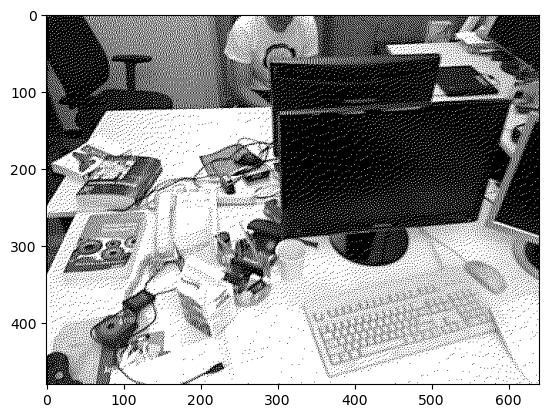

In [217]:
plt.imshow(q_img, cmap="gray")

In [272]:
w

array([[0.   , 0.   , 0.425],
       [0.125, 0.375, 0.075]])

In [278]:
if not None:
    print("yes")

yes


In [15]:
isinstance(None, type(None))

True

In [12]:
type(None)

NoneType

In [50]:
[1, list(np.linspace(0, 10, 10))]*4

[1,
 [0.0,
  1.1111111111111112,
  2.2222222222222223,
  3.3333333333333335,
  4.444444444444445,
  5.555555555555555,
  6.666666666666667,
  7.777777777777779,
  8.88888888888889,
  10.0],
 1,
 [0.0,
  1.1111111111111112,
  2.2222222222222223,
  3.3333333333333335,
  4.444444444444445,
  5.555555555555555,
  6.666666666666667,
  7.777777777777779,
  8.88888888888889,
  10.0],
 1,
 [0.0,
  1.1111111111111112,
  2.2222222222222223,
  3.3333333333333335,
  4.444444444444445,
  5.555555555555555,
  6.666666666666667,
  7.777777777777779,
  8.88888888888889,
  10.0],
 1,
 [0.0,
  1.1111111111111112,
  2.2222222222222223,
  3.3333333333333335,
  4.444444444444445,
  5.555555555555555,
  6.666666666666667,
  7.777777777777779,
  8.88888888888889,
  10.0]]

In [ ]:
# @numba.njit
# def halftone_error_diffusion(img, w):
    
#     if w.shape == (2, 3):
#         FSTEPJ = 1
#         BSTEPJ = -1
#         FSTEPI = 1
        
#     if w.shape == (3, 5):
#         FSTEPJ = 2
#         BSTEPJ = -2
#         FSTEPI = 2 
        
#     tmp1 = np.concatenate((np.ones((img.shape[0], -BSTEPJ)), img, np.ones((img.shape[0], FSTEPJ))), axis=1)
#     tmp2 = np.concatenate((np.ones((FSTEPI, -BSTEPJ)), np.ones((FSTEPI, img.shape[1])), np.ones((FSTEPI, FSTEPJ))), axis=1)
#     tmp = np.concatenate((tmp1, tmp2), axis=0)

#     newImage = np.zeros((img.shape[0]+FSTEPI, img.shape[1]+FSTEPJ - BSTEPJ), dtype=np.int64)

#     for i in range(img.shape[0]):
#         for j in range(img.shape[1]+FSTEPJ):
#             if (i > img.shape[0] or j > img.shape[1] - BSTEPJ or j <= -BSTEPJ):
#                     newImage[i,j] = 255 if tmp[i,j] > 128 else 0
#             else:
#                 err1 = tmp[i,j] - 0
#                 err2 = tmp[i,j] - 255

#                 if (err1 * err1 < err2 * err2):
#                     newImage[i,j] = 0
#                     err3 = err1
#                 else:
#                     newImage[i,j] = 255
#                     err3 = err2

#                 for k in range(1, FSTEPI + 2):
#                     for l in range(BSTEPJ, FSTEPJ+1):
#                         tmp[i+k-1, j+l] += err3 * w[k-1, -1*BSTEPJ+l]
    
#     quantized_img = newImage[:-FSTEPI, :-(FSTEPJ-BSTEPJ)]
    
#     return quantized_img.astype(np.uint8)


# class ORBFilterGA(object):
#     def __init__(self, nfeatures1bit=1000, scaleFactor1bit=1.2, nlevels1bit=8,
#                        num_generations=100, num_parents_mating=4, sol_per_pop=10, num_genes=12, gene_space=float,
#                        init_range_low=0, init_range_high=1, parent_selection_type="sss", keep_parents=2, 
#                        crossover_type="single_point", mutation_type="random", mutation_percent_genes=33):
        
#         self.nfeatures    = nfeatures1bit
#         self.scaleFactor  = scaleFactor1bit
#         self.nlevels      = nlevels1bit
        
#         self.imgs = None
#         self.ga_instance = None
        
#         self.num_generations = num_generations
#         self.num_parents_mating = num_parents_mating
#         self.sol_per_pop = sol_per_pop
#         self.num_genes = num_genes              # 4(6-2) or 12(15-3)
#         self.gene_space = gene_space            # w_range + orbparams
#         self.init_range_low  = init_range_low
#         self.init_range_high = init_range_high
#         self.parent_selection_type = parent_selection_type
#         self.keep_parents = keep_parents
#         self.crossover_type = crossover_type
#         self.mutation_type = mutation_type
#         self.mutation_percent_genes = mutation_percent_genes
        
#         self.acc_ave = None
    
    
#     def set_dataset_and_config(self, directory=None, imgs=None, N=-1, num_genes=None, gene_space=None):
#         if imgs:
#             self.imgs = imgs
        
#         if directory:
#             img_paths = glob(f"{directory}*")

#             if N != -1: img_paths = np.random.choice(img_paths, N)

#             self.imgs = []

#             for path in img_paths:
#                 img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
#                 self.imgs.append(img) 
        
#         if type(num_genes)  != type(None):   self.num_genes  = num_genes
#         if type(gene_space) != type(None):   self.gene_space = gene_space 
        
#         print(f"Dataset and config parameters has been ready!")
#         print(f"All {len(self.imgs)} imgs in dataset!")
    
    
#     def halftone_error_diffusion(self, img, w):
#         return halftone_error_diffusion(img, w)
    
    
#     def orb_matching_accuracy(self, img_8bit, img_1bit, extractor_params=None):

#         orb_8bit = cv2.ORB_create(
#                 nfeatures     = 1000,
#                 scaleFactor   = 1.2,
#                 nlevels       = 8,
#         )

#         orb_1bit = cv2.ORB_create(
#                 nfeatures     = self.nfeatures,
#                 scaleFactor   = self.scaleFactor,
#                 nlevels       = self.nlevels,
#         )

#         try:
#             keypoints_8bit, descriptors_8bit = orb_8bit.detectAndCompute(img_8bit, None)
#             keypoints_1bit, descriptors_1bit = orb_1bit.detectAndCompute(img_1bit, None)

#             bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
#             matches = bf.match(descriptors_8bit, descriptors_1bit)
#             min_dist = 10000
#             max_dist = 0

#             for match in matches:
#                 dist = match.distance
#                 if dist < min_dist:
#                     min_dist = dist
#                 if dist > max_dist:
#                     max_dist = dist

#             good_matches = []

#             for match in matches:
#                 if match.distance <= max(2 * min_dist, 30.0):
#                     good_matches.append(match)

#             acc = len(good_matches)/len(descriptors_8bit)

#         except Exception as e:
#             acc = 0

#         return acc

    
#     def target_function(self, w):
            
#         accs = []
#         w = list(np.array(w) / np.sum(w))

#         if len(w) == 6-2:  w = np.array([0,0] + list(w)).reshape(2, 3)
#         if len(w) == 15-3: w = np.array([0,0,0] + list(w)).reshape(3, 5)
        
#         for img in self.imgs:
#             quantized_img = self.halftone_error_diffusion(img, w)
#             acc = self.orb_matching_accuracy(img, quantized_img)
#             accs.append(acc)

#         self.acc_ave = np.mean(accs)
        
#         return self.acc_ave
    
    
#     def fitness_func(self, ga_instance, solution, solution_idx):
        
#         if len(solution) not in [4, 12]:
#             self.nfeatures   = int(solution[0])
#             self.scaleFactor = solution[1]
#             self.nlevels     = int(solution[2])
#             solution         = solution[3:]
        
#         solution_fitness = self.target_function(solution) * 100
#         return solution_fitness
        
        
#     def optimizationGA(self):
            
#         ga_instance = pygad.GA(num_generations=self.num_generations,
#                        num_parents_mating=self.num_parents_mating, 
#                        fitness_func=self.fitness_func,
#                        sol_per_pop=self.sol_per_pop, 
#                        num_genes=self.num_genes,
#                        gene_space=self.gene_space,
#                        parent_selection_type=self.parent_selection_type,
#                        keep_parents=self.keep_parents,
#                        crossover_type=self.crossover_type,
#                        init_range_low=self.init_range_low,
#                        init_range_high=self.init_range_high,
#                        mutation_type=self.mutation_type,
#                        mutation_percent_genes=self.mutation_percent_genes)

#         ga_instance.run()
        
#         self.ga_instance = ga_instance
    
    
#     def show_result(self):
#         self.ga_instance.plot_fitness()

#         solution, solution_fitness, solution_idx = self.ga_instance.best_solution()
        
#         print(f"Parameters of the best solution:")
#         print(f"[nfeatures]  : {solution[0]}")
#         print(f"[scaleFactor]: {solution[1]}")
#         print(f"[nlevels]    : {solution[2]}")
#         print(f"[filter]     : {list(np.array(solution[3:])/np.mean(solution[3:]))}")
#         print(f"Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))